# Lab. 6 - Variable selection

In this lab we will move to considering the problems of variable selection in classification (thus supervised) scenarios.

As usual, we start importing libraries and functions already used in one of the previous labs.

In [291]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

rnd_state = np.random.RandomState(12)

### Data generation

To generate a synthetic dataset suitable for use with variable selection, we first generate a subset of "relevant" features, and then concatenate with a second set of "dummy", irrelevant featuers. To this purpose,  we proceed as follows:
- Generate a dataset with the `mixGauss` function: use two Gaussians which are *close* with each other (see example below). Start by considering 2-Dimensional points
- Plot the points: you should observe two point-clouds which mix with each other (since they were generated with the same parameters).
- Enrich the input samples with "dummy" features randomly sampled and concatenate to the relevant features (notice that at this point data visualization is no more possible


In [292]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = rnd_state.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

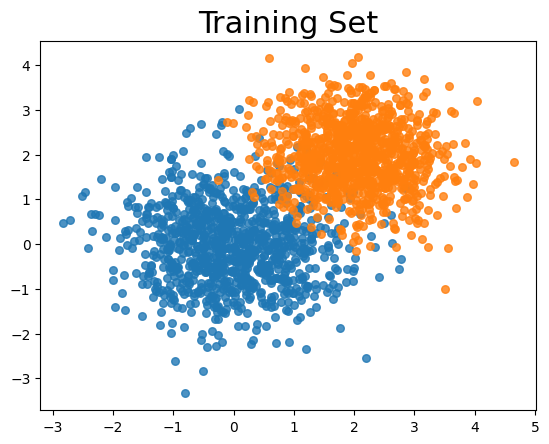

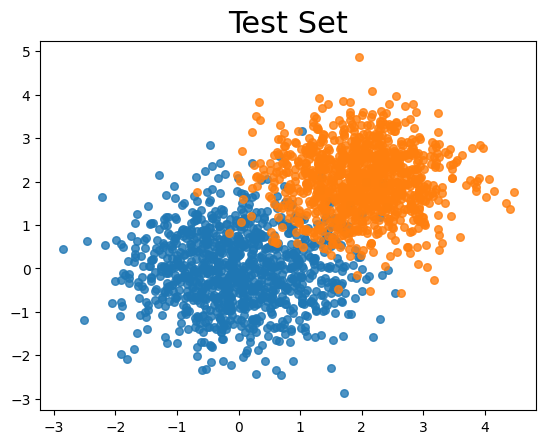

In [293]:
n=1000     # number of features for each gaussian
d=30       # total number of features
d_rev = 2  # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)
Xte, Yte = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)

# plot
fig, ax = plt.subplots()
ax.set_title("Training Set", fontsize=22)
ax.scatter(Xtr[Ytr==-1,0], Xtr[Ytr==-1,1], s=30, alpha=0.80)
ax.scatter(Xtr[Ytr==1,0], Xtr[Ytr==1,1], s=30, alpha=0.80)

fig, ax = plt.subplots()
ax.set_title("Test Set", fontsize=22)
ax.scatter(Xte[Yte==-1,0], Xte[Yte==-1,1], s=30, alpha=0.80)
ax.scatter(Xte[Yte==1,0], Xte[Yte==1,1], s=30, alpha=0.80);

In [294]:
# dummy features generation
sigma_noise = 0.13
Xtr_noise = sigma_noise * rnd_state.randn(2*n, d-d_rev)
Xtr = np.concatenate((Xtr,Xtr_noise), axis=1)
Xte_noise = sigma_noise * rnd_state.randn(2*n, d-d_rev)
Xte = np.concatenate((Xte,Xte_noise), axis=1)

In [295]:
Xtr.shape

(2000, 30)

## Variable selection

##### OMatchingPursuit

It computes a sparse representation of the signal using Orthogonal Matching Pursuit algorithm. Use it as follows:
    
`w, r, I = OMatchingPursuit( X, Y, T)`

where
    - X: input data
    - Y: output labels
    - T: number of iterations
    - w: estimated coefficients
    - r: residuals
    - I: indices


In [296]:
def OMatchingPursuit(X, Y, T):

    N, D = np.shape(X)

    # 1. Initialization of residual, coefficient vector and index set I
    r = Y.copy()
    w = np.zeros(D)
    I = []

    for i in range(T):
        # 2. Select the column of X which coefficients most "explains" the residual
        a_max = -np.inf
        j_max = None

        for j in range(D):
            # correlation between column j and residual
            a_tmp = np.abs(X[:, j].T.dot(r))

            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j

        # 3. Add the index to the set of indexes
        assert j_max is not None, "OMP failed to select a coordinate — check correlation computation."
        if j_max not in I:
            I.append(j_max)

        # Compute the M matrix
        M_I = np.zeros((D, D))
        for j in I:
            M_I[j, j] = 1

        A = M_I.dot(X.T).dot(X).dot(M_I)
        B = M_I.dot(X.T).dot(Y)

        # 4. Update estimated coefficients
        w = la.pinv(A).dot(B)

        # 5. Update the residual
        r = Y - X.dot(w)

    return w, r, I

In [297]:
# Usual function to compute the error in predicted labels (for a binary classification problem)
def calcError(Ypred, Y):
    V = np.multiply(np.sign(Ypred), np.sign(Y))
    return np.count_nonzero(V < 0) / len(Y)

In [298]:
# K-Fold Cross Validation for selecting the best value for the hyperparameters in the use of 
# Orthogonal Matching Pursuit (we refer to the number of iterations)

def KFoldCVOMP(Xtr, Ytr, KF, niter_list):
    """
    K-Fold Cross Validation to select the best number of iterations for OMP.

    Returns:
        best_niter, Vm, Vs, Tm, Ts
    """
    assert KF > 1, "KF must be an integer >= 2"
    n_tot = Xtr.shape[0]
    assert KF <= n_tot, "KF cannot be larger than the number of samples"

    # Ensure numpy array
    niter_list = np.array(niter_list, dtype=int)
    num_niter = niter_list.size

    # Random permutation of training data
    rand_idx = rnd_state.permutation(n_tot)

    # Size of each validation fold (may leave a remainder)
    n_val = n_tot // KF  # integer division

    # Accumulators: sums over folds
    Tm = np.zeros(num_niter, dtype=float)  # mean training error accumulator
    Ts = np.zeros(num_niter, dtype=float)  # second moment of training error
    Vm = np.zeros(num_niter, dtype=float)  # mean validation error accumulator
    Vs = np.zeros(num_niter, dtype=float)  # second moment of validation error

    for kdx, niter in enumerate(niter_list):
        # Reset fold pointer per hyperparameter so folds are identical for each niter
        first = 0

        for fold in range(KF):
            start = fold * n_val
            end = (fold + 1) * n_val if fold < KF - 1 else n_tot  # last fold uses all remaining

            val_idx = rand_idx[start:end]
            train_idx = np.setdiff1d(rand_idx, val_idx, assume_unique=True)

            X = Xtr[train_idx]
            Y = Ytr[train_idx]
            X_val = Xtr[val_idx]
            Y_val = Ytr[val_idx]

            # Train OMP
            w, r, I = OMatchingPursuit(X, Y, niter)

            # Training error
            YpredTR = np.sign(X.dot(w))
            trError = calcError(YpredTR, Y)
            Tm[kdx] += trError
            Ts[kdx] += trError ** 2

            # Validation error
            YpredVAL = np.sign(X_val.dot(w))
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] += valError
            Vs[kdx] += valError ** 2

    # Average over folds
    Tm /= KF
    Ts = Ts / KF - Tm**2  # variance estimate

    Vm /= KF
    Vs = Vs / KF - Vm**2  # variance estimate

    # Sometimes tiny negative variances appear due to numerical issues
    Ts = np.maximum(Ts, 0.0)
    Vs = np.maximum(Vs, 0.0)

    best_niter_idx = np.argmin(Vm)
    best_niter = niter_list[best_niter_idx]

    print("Validation mean errors:", Vm)
    print("niter_list:", niter_list)
    print("Best index:", best_niter_idx)

    return best_niter, Vm, Vs, Tm, Ts

### Some analysis

We suggest to proceed as follows:

- Standardize the data
- Run Orthogonal Matching Pursuit on the training set setting a reasonable number of iterations
- Compute the prediction on the test set and evaluate the error
- Plot the components of the solution w (considering their absolute value): how do they look?
- Run the K-Fold Cross Validation to select an appropriate value for the number of iterations


In [299]:
# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr - m), s)
Xtenorm = np.divide((Xte - m), s)

Test error with T=2: 0.042


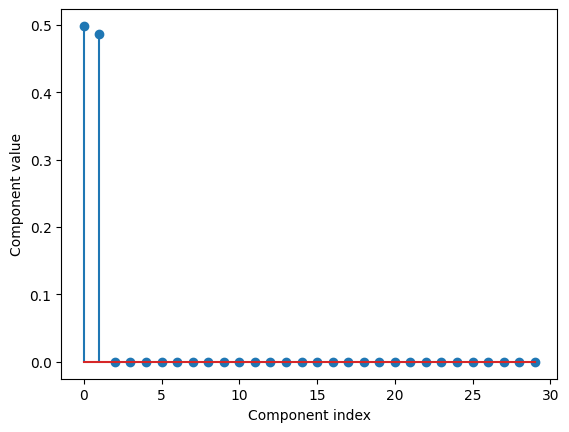

In [300]:
# Run Orthogonal Matching Pursuit
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, T=2)

# Compute the prediction on the test set
YpredTE = np.sign(Xtenorm.dot(w))

# Compute the test error and show its value
testError = calcError(YpredTE, Yte)
print("Test error with T=2:", testError)

# Plot the components of the solution w
plt.subplots()
plt.stem(w)
plt.xlabel("Component index")
plt.ylabel("Component value")
plt.show()

Validation mean errors: [0.1105 0.037  0.0395 0.0405 0.0395 0.039  0.038 ]
niter_list: [ 1  2  3  4  5 10 30]
Best index: 1
Best number of iterations: 2


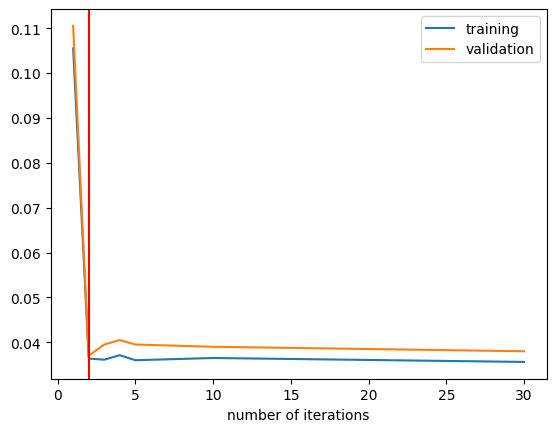

In [301]:
# run K-Fold Cross Validation
KF = 5
niter_list = [1, 2, 3, 4, 5, 10, d] 
best_niter, Vm, Vs, Tm, Ts = KFoldCVOMP(Xtrnorm, Ytr, KF, niter_list)

# Plot training and validation error
plt.subplots()
plt.plot(niter_list, Tm, label="training")
plt.plot(niter_list, Vm, label="validation")
plt.legend(loc="best")
plt.xlabel("number of iterations")
plt.axvline(best_niter, color="red")
print(f'Best number of iterations: {best_niter}')

We can also shuffle columns of the synthetic dataset in order to observe the behavior of OMP

In [302]:
# Shuffle columns
shuffle_idx = rnd_state.choice(Xtr.shape[1], Xtr.shape[1], replace=False)

Xtr = Xtr[:, shuffle_idx]
Xte = Xte[:, shuffle_idx]

In [303]:
print(f"[--] The relevant features are {(shuffle_idx == 0).argmax()} and {(shuffle_idx == 1).argmax()}")

[--] The relevant features are 11 and 9


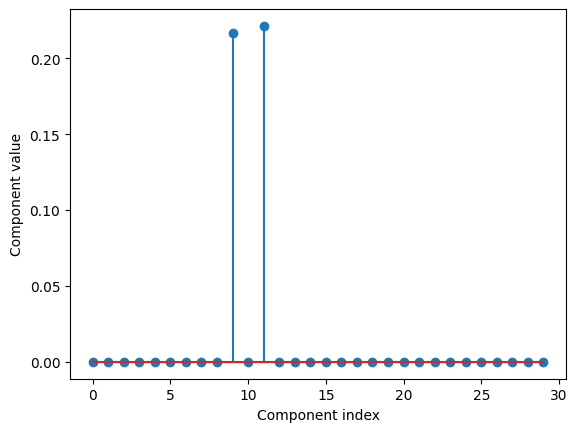

[--] The selected features are [11, 9]


In [304]:
# Run OMP and verify that it is able to find the relevant features
w, r, I = OMatchingPursuit(Xtr, Ytr, T=2)

# Plot the components of the solution w
plt.subplots()
plt.stem(w)
plt.xlabel("Component index")
plt.ylabel("Component value")
plt.show()

# print the selected features
print(f"[--] The selected features are {I}")

Increase the number of relevant and dummy features and observe the behavior of OMP 

Test error with T=10: 0.5


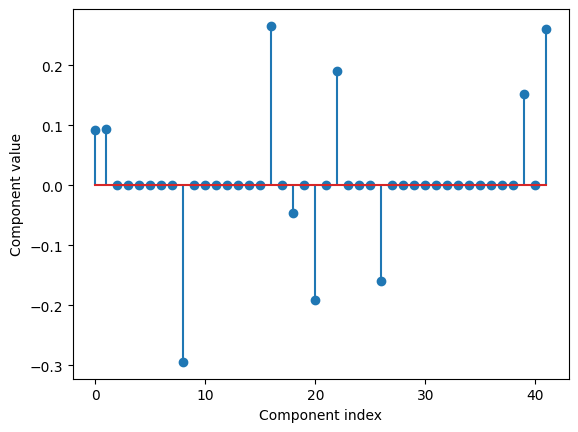

In [305]:
# Insert your code here
n=1000     # number of features for each gaussian
d=50       # total number of features
d_rev =10  # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)
Xte, Yte = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)

# dummy features generation
sigma_noise = 0.13
Xtr_noise = np.cumsum(sigma_noise * rnd_state.randn(2*n, d-d_rev), axis=0)
Xtr = np.concatenate((Xtr, Xtr_noise), axis=1)
Xte_noise = np.cumsum(sigma_noise * rnd_state.randn(2*n, d-d_rev), axis=0)
Xte = np.concatenate((Xte, Xte_noise), axis=1)


# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr - m), s)
Xtenorm = np.divide((Xte - m), s)

# Run Orthogonal Matching Pursuit
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, T=10)

# Compute the prediction on the test set
YpredTE = np.sign(Xtenorm.dot(w))

# Compute the test error and show its value
testError = calcError(YpredTE, Yte)
print("Test error with T=10:", testError)

# Plot the components of the solution w
plt.subplots()
plt.stem(w)
plt.xlabel("Component index")
plt.ylabel("Component value")
plt.show()